# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|OK|
|2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.|seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.|OK|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.|OK|

### dataset
1. 프랑스어와 영어의 병렬 코퍼스
   * [fra-eng.zip](https://www.manythings.org/anki/)
   * Random 33,000 개의 sample 

### sequence-to-sequence model 설계
1. RNN (LTSM)
   * Encorder
   * Decorder

## 문제 정의  

> Word-level Machine Translation 만들기  
> RNN을 사용한 word-level seq2seq로 기계 번역기를 만들기   

## 라이브러리 버전 확인

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow

print(tensorflow.__version__)

2.6.0


In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
import numpy as np
import sklearn
import re

In [3]:
import os
file_path = './data/fra.txt'

lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력
lines.head()

전체 샘플의 수 : 197463


,eng,fra,cc
126320,The tower can be seen from here.,La tour peut être vue d'ici.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
142200,It may be that he is not a bad man.,Il se peut qu'il ne soit pas un homme mauvais.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
143118,The problem is being discussed now.,On est en train de parler du problème en ce mo...,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
85098,You're very sophisticated.,Vous êtes très raffiné.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
176390,Tom asked Mary who had given her the picture.,Tom a demandé à Mary qui lui a donné la photo.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


* 33000개의 random sample 사용

In [4]:
lines = sklearn.utils.shuffle(lines)
lines = lines[['eng', 'fra']][:33000] # 33000 샘플 사용
lines.sample(5)

,eng,fra
84023,What did you get hit with?,Avec quoi avez-vous été frappée ?
179408,I'm thinking of visiting you one of these days.,Je pense à te rendre visite un de ces quatre.
127921,You should've gotten up earlier.,Vous auriez dû vous lever plus tôt.
22856,Did you eat lunch?,As-tu pris un déjeuner ?
105898,This hat is too small for me.,Ce chapeau est trop petit pour moi.


In [5]:
#상위 5개 sample
lines.head()

,eng,fra
74256,Take this to your mother.,Apporte ceci à ta mère.
5645,Make a guess.,Hasarde une hypothèse !
193849,"Wimbledon has eighteen grass courts, including...","Wimbledon a dix-huit courts sur gazon, dont le..."
34765,Do you want a salad?,Tu veux une salade ?
148582,"Unfortunately, I missed all the fun.","Malheureusement, j'ai loupé tout l'amusement."


## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

1. 구두점(Punctuation)을 단어와 분리
   * !나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)
2. 소문자로 바꾸기
3. 띄어쓰기 단위로 토큰화 수행

In [6]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    #sentence = '<sos> ' + sentence + ' <eos>' # 6

    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("Ouvre-moiv !.    "))

ouvre moiv ! .


* englsih : 정제된 문장 eng_corpus 

In [7]:
# 여기에 정제된 문장을 모을겁니다
eng_corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in lines['eng']:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: 
        print(sentence)
        continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    eng_preprocessed_sentence = preprocess_sentence(sentence)
    eng_corpus.append(eng_preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
len(eng_corpus)
eng_corpus[:20]

33000

['take this to your mother .',
 'make a guess .',
 'wimbledon has eighteen grass courts , including the center court .',
 'do you want a salad ?',
 'unfortunately , i missed all the fun .',
 'are you following me ?',
 'we want to see the king .',
 'we ll never catch tom .',
 'how will you be spending christmas ?',
 'a beautiful sunset , isn t it ?',
 'it s a girl thing .',
 'you should get married again .',
 'almost everyone was dead .',
 'it is no good to you .',
 'she invited us to her birthday party .',
 'is this book boring ?',
 'i bought it .',
 'i understood what you meant .',
 'slavery is a crime against humanity .',
 'i m not like the rest of these guys .']

## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

* franch : 정제된 문장 fra_corpus 
* 입력 시퀀스 : ['\<sos\>', 'courez', '!']
* 레이블 시퀀스 : ['courez', '!', '\<eos\>']

In [8]:
# 여기에 정제된 문장을 모을겁니다
fra_corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in lines['fra']:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
       
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    fra_preprocessed_sentence = preprocess_sentence(sentence)
    fra_preprocessed_sentence = '<sos> ' + fra_preprocessed_sentence + ' <eos>' # 6
    fra_corpus.append(fra_preprocessed_sentence)
            
# 정제된 결과를 10개만 확인해보죠
len(fra_corpus)
fra_corpus[:20]

33000

['<sos> apporte ceci ta m re . <eos>',
 '<sos> hasarde une hypoth se ! <eos>',
 '<sos> wimbledon a dix huit courts sur gazon , dont le court central . <eos>',
 '<sos> tu veux une salade ? <eos>',
 '<sos> malheureusement , j ai loup tout l amusement . <eos>',
 '<sos> est ce que vous me suivez ? <eos>',
 '<sos> nous voulons voir le roi . <eos>',
 '<sos> nous n attraperons jamais tom . <eos>',
 '<sos> comment passeras tu no l ? <eos>',
 '<sos> joli coucher de soleil , n est ce pas ? <eos>',
 '<sos> c est un truc de filles . <eos>',
 '<sos> vous devriez vous remarier . <eos>',
 '<sos> presque tout le monde tait mort . <eos>',
 '<sos> a ne te fait pas du bien . <eos>',
 '<sos> elle nous invita sa f te d anniversaire . <eos>',
 '<sos> est ce que ce livre est ennuyant ? <eos>',
 '<sos> je l ai achet . <eos>',
 '<sos> j ai compris ce que vous vouliez dire . <eos>',
 '<sos> l esclavage est un crime contre l humanit . <eos>',
 '<sos> je ne suis pas comme le reste de ces types . <eos>']

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

* tf.keras.preprocessing.text.Tokenizer

In [9]:
eng_tokenizer = Tokenizer(filters=' ')   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(eng_corpus)               # eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(eng_corpus)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[98, 17, 4, 28, 207, 1],
 [109, 7, 406, 1],
 [4713, 75, 2891, 1644, 3567, 23, 4714, 5, 1362, 2171, 1],
 [15, 3, 34, 7, 1530, 6],
 [1363, 23, 2, 609, 45, 5, 327, 1],
 [31, 3, 1281, 20, 6],
 [22, 34, 4, 82, 5, 1364, 1],
 [22, 49, 101, 491, 10, 1],
 [43, 65, 3, 33, 1105, 185, 6],
 [7, 318, 2892, 23, 129, 8, 12, 6]]

In [10]:
eng_tokenizer.index_word

{1: '.',
 2: 'i',
 3: 'you',
 4: 'to',
 5: 'the',
 6: '?',
 7: 'a',
 8: 't',
 9: 'is',
 10: 'tom',
 11: 'that',
 12: 'it',
 13: 's',
 14: 'he',
 15: 'do',
 16: 'of',
 17: 'this',
 18: 'in',
 19: 'don',
 20: 'me',
 21: 'have',
 22: 'we',
 23: ',',
 24: 'was',
 25: 'what',
 26: 'my',
 27: 'can',
 28: 'your',
 29: 'm',
 30: 'for',
 31: 'are',
 32: 're',
 33: 'be',
 34: 'want',
 35: 'she',
 36: 'not',
 37: 'like',
 38: 'on',
 39: 'know',
 40: 'with',
 41: 'they',
 42: 'did',
 43: 'how',
 44: 'go',
 45: 'all',
 46: 'his',
 47: 'at',
 48: 'think',
 49: 'll',
 50: 'and',
 51: 've',
 52: 'there',
 53: 'about',
 54: 'here',
 55: 'him',
 56: 'time',
 57: 'get',
 58: 'very',
 59: 'didn',
 60: 'were',
 61: 'one',
 62: 'no',
 63: 'out',
 64: 'going',
 65: 'will',
 66: 'up',
 67: 'if',
 68: 'had',
 69: 'why',
 70: 'her',
 71: 'd',
 72: 'as',
 73: 'just',
 74: 'who',
 75: 'has',
 76: 'so',
 77: 'would',
 78: 'need',
 79: 'let',
 80: 'mary',
 81: 'come',
 82: 'see',
 83: 'when',
 84: 'from',
 85: 'goo

In [11]:
fra_tokenizer = Tokenizer(filters=' ')   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(fra_corpus)                 # fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(fra_corpus)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 2334, 158, 128, 33, 41, 3, 2],
 [1, 6119, 30, 2125, 60, 43, 2],
 [1, 6120, 11, 401, 1076, 3006, 74, 4467, 25, 365, 13, 751, 4468, 3, 2],
 [1, 17, 56, 30, 1785, 6, 2],
 [1, 1557, 25, 20, 26, 1558, 54, 18, 6121, 3, 2],
 [1, 8, 22, 10, 9, 31, 3565, 6, 2],
 [1, 28, 618, 118, 13, 1676, 3, 2],
 [1, 28, 21, 4469, 93, 19, 3, 2],
 [1, 91, 6122, 17, 185, 18, 6, 2],
 [1, 2608, 1150, 5, 644, 25, 21, 8, 22, 7, 6, 2]]

In [12]:
fra_tokenizer.index_word

{1: '<sos>',
 2: '<eos>',
 3: '.',
 4: 'je',
 5: 'de',
 6: '?',
 7: 'pas',
 8: 'est',
 9: 'vous',
 10: 'que',
 11: 'a',
 12: 'il',
 13: 'le',
 14: 'ne',
 15: 'd',
 16: 'la',
 17: 'tu',
 18: 'l',
 19: 'tom',
 20: 'j',
 21: 'n',
 22: 'ce',
 23: 's',
 24: 'un',
 25: ',',
 26: 'ai',
 27: 't',
 28: 'nous',
 29: 'en',
 30: 'une',
 31: 'me',
 32: 'les',
 33: 'm',
 34: 'c',
 35: 'suis',
 36: 'pour',
 37: 'e',
 38: 'te',
 39: 'qu',
 40: 'elle',
 41: 're',
 42: 'faire',
 43: '!',
 44: 'r',
 45: 'des',
 46: 'dans',
 47: 'plus',
 48: 'tes',
 49: 'tre',
 50: 'es',
 51: 'qui',
 52: 'moi',
 53: 'y',
 54: 'tout',
 55: 'tait',
 56: 'veux',
 57: 'du',
 58: 'avec',
 59: 'au',
 60: 'se',
 61: 'fait',
 62: 'mon',
 63: 'si',
 64: 'as',
 65: 'et',
 66: 'pr',
 67: 'sont',
 68: 'avez',
 69: 'ils',
 70: 'on',
 71: 'cette',
 72: 'tr',
 73: 'peux',
 74: 'sur',
 75: 'cela',
 76: 'votre',
 77: 'ici',
 78: 'son',
 79: 'temps',
 80: 'dit',
 81: 'ma',
 82: 'sais',
 83: 'lui',
 84: 'pourquoi',
 85: 'chose',
 86: 'pense

In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 8028
프랑스어 단어장의 크기 : 10891


In [14]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 34
프랑스어 시퀀스의 최대 길이 44


In [15]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 8028
영어 시퀀스의 최대 길이 34
프랑스어 단어장의 크기 : 10891
프랑스어 시퀀스의 최대 길이 44


* encoder 입력(eng) : encoder_input
* decoder 입력( \<sos\> + fra) : decorder_input <- teaching forcing
* decoder 정답(fra + \<eos\> ) : decorder_target 

In [16]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ word for word in line if word != fra_tokenizer.word_index['<eos>'] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ word for word in line if word != fra_tokenizer.word_index['<sos>'] ] for line in target_text]

In [17]:
#디코더의 입력과 출력
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 2334, 158, 128, 33, 41, 3], [1, 6119, 30, 2125, 60, 43], [1, 6120, 11, 401, 1076, 3006, 74, 4467, 25, 365, 13, 751, 4468, 3]]
[[2334, 158, 128, 33, 41, 3, 2], [6119, 30, 2125, 60, 43, 2], [6120, 11, 401, 1076, 3006, 74, 4467, 25, 365, 13, 751, 4468, 3, 2]]


* padding 

In [18]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 34)
프랑스어 입력데이터의 크기(shape) : (33000, 44)
프랑스어 출력데이터의 크기(shape) : (33000, 44)


In [19]:
print(encoder_input[0])
print(decoder_input[0])
print(decoder_target[0])

[ 98  17   4  28 207   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[   1 2334  158  128   33   41    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[2334  158  128   33   41    3    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


* train set/ validation set 분리

In [20]:
n_of_val = 3000 

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

#print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
#print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
#print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

print('영어 검증데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 검증 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 검증 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (30000, 34)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 44)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 44)
영어 검증데이터의 크기(shape) : (3000, 34)
프랑스어 검증 입력데이터의 크기(shape) : (3000, 44)
프랑스어 검증 출력데이터의 크기(shape) : (3000, 44)


## Step 4. 임베딩 층(Embedding layer) 사용하기

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [22]:
eng_vocab_size
fra_vocab_size

8028

10891

* 임베딩 벡터의 차원과 LSTM의 은닉 상태의 크기

In [23]:
embedding_dim = 256
hidden_units = 256

* Encoder 설계
  * Masking 은 토큰인 숫자 0의 경우에는 연산에서 제외하는 역할 수행
  * LSTM return_state=True 로 설정( encoder의 내부상태를 decoder에 넘겨줌)
  * context vector : encoder_state 를 decoder에 전달하기 위해 저장
    * state_h : hidden state 
    * state_c : cell state

In [24]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

* Decoder 설계

In [25]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


## Step 5. 모델 구현하기

In [26]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2055168     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2788096     input_2[0][0]                    
______________________________________________________________________________________________

In [27]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 27s 82ms/step - loss: 1.6951 - acc: 0.7980 - val_loss: 1.1394 - val_acc: 0.8298
Epoch 2/50
235/235 [==============================] - 17s 74ms/step - loss: 1.0671 - acc: 0.8354 - val_loss: 1.0468 - val_acc: 0.8366
Epoch 3/50
235/235 [==============================] - 18s 75ms/step - loss: 0.9904 - acc: 0.8419 - val_loss: 0.9863 - val_acc: 0.8427
Epoch 4/50
235/235 [==============================] - 18s 76ms/step - loss: 0.9140 - acc: 0.8512 - val_loss: 0.9113 - val_acc: 0.8540
Epoch 5/50
235/235 [==============================] - 18s 77ms/step - loss: 0.8371 - acc: 0.8604 - val_loss: 0.8509 - val_acc: 0.8610
Epoch 6/50
235/235 [==============================] - 18s 78ms/step - loss: 0.7725 - acc: 0.8676 - val_loss: 0.8009 - val_acc: 0.8665
Epoch 7/50
235/235 [==============================] - 18s 77ms/step - loss: 0.7150 - acc: 0.8744 - val_loss: 0.7640 - val_acc: 0.8710
Epoch 8/50
235/235 [==============================] - 18s 77ms

* 학습 결과에 대한 그래프를 시각화
  * train loss / val loss

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

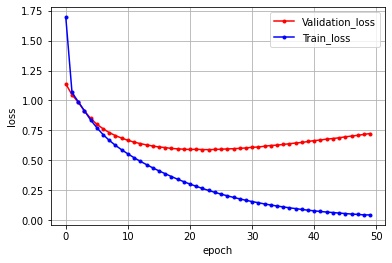

In [28]:
import matplotlib.pyplot as plt

# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Validation_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Train_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

* 학습 결과에 대한 그래프를 시각화
  * train acc / val acc

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'accuracy')

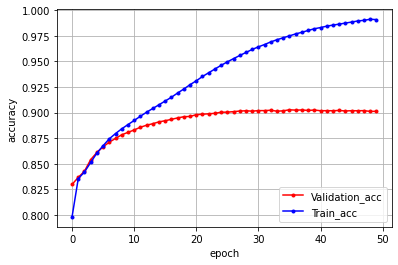

In [29]:
# 검증셋과 학습셋의 accuracy 저장
y_vacc = history.history['val_acc']
y_acc = history.history['acc']

# 그래프로 표현
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, marker='.', c="red", label='Validation_acc')
plt.plot(x_len, y_acc, marker='.', c="blue", label='Train_acc')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='lower right')
plt.grid()

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Step 6. 모델 평가하기

* 테스트 Encoder 설계  
인코더의 입, 출력으로 사용하는 encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용

In [30]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         2055168   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 2,580,480
Trainable params: 2,580,480
Non-trainable params: 0
_________________________________________________________________


* 테스트 디코더 설계

In [31]:
# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2788096     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [32]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

* decode_sequence 함수를 구현

In [33]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra2idx['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if sampled_char == '<eos>':
       stop_condition = True
    if len(decoded_sentence) > max_fra_seq_len:
        stop_condition = True
        print(len(decoded_sentence))

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

* 결과 확인을 위한 함수

In [34]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx['<sos>'] and encoded_word != fra2idx['<eos>']):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

* 출력 결과 테스트

In [35]:
for seq_index in [30, 500, 1000, 3000, 3002]:
  input_seq = encoder_input[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

45
입력문장 : there was a cold wind blowing from the north . 
정답문장 : il y avait un vent froid soufflant du nord . 
번역문장 : il y avait un vent froid soufflant du n
--------------------------------------------------
입력문장 : how was the fishing ? 
정답문장 : comment tait la p che ? 
번역문장 : comment tait la p che ? 
--------------------------------------------------
입력문장 : i beg you . 
정답문장 : je vous en supplie . 
번역문장 : je vous en supplie . 
--------------------------------------------------
47
입력문장 : i ve never read a novel in french . 
정답문장 : je n ai jamais lu de roman en fran ais . 
번역문장 : je n ai jamais lu de roman en fran ais . 
--------------------------------------------------
입력문장 : we ve got to be careful . 
정답문장 : nous devons tre prudentes . 
번역문장 : nous devons tre prudentes . 
--------------------------------------------------


* 훈련 데이터로 출력 결과 테스트

In [36]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : do you want a salad ? 
정답문장 : tu veux une salade ? 
번역문장 : tu veux une salade ? 
--------------------------------------------------
입력문장 : he s about the same age as you are . 
정답문장 : il a peu pr s le m me ge que toi . 
번역문장 : il a peu pr s le m me ge que toi . 
--------------------------------------------------
46
입력문장 : the company presented him with a gold watch on the day he retired . 
정답문장 : la soci t lui offrit une montre en or le jour de son d part . 
번역문장 : la soci t lui offrit une montre en or le
--------------------------------------------------
46
입력문장 : given her inexperience , she has done well . 
정답문장 : tant donn son inexp rience , elle a bien fait . 
번역문장 : tant donn son inexp rience , elle a bien
--------------------------------------------------
47
입력문장 : how often do you use your phone ? 
정답문장 : quelle fr quence utilises tu ton t l phone ? 
번역문장 : quelle fr quence utilisez vous votre t l 
--------------------------------------------------


* 테스트 데이터로 출력 결과 테스트

In [37]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

48
입력문장 : i wish i d followed tom s advice . 
정답문장 : j aurais d suivre le conseil de tom . 
번역문장 : j aimerais que tom a t stupide de jouer . 
--------------------------------------------------
48
입력문장 : i realized i couldn t win . 
정답문장 : je pris conscience que je ne pouvais gagner . 
번역문장 : je pris conscience que je ne pouvais l emp
--------------------------------------------------
입력문장 : you need a joystick . 
정답문장 : vous avez besoin d une manette de jeu . 
번역문장 : tu as besoin d un endroit . 
--------------------------------------------------
입력문장 : are you up ? 
정답문장 : es tu lev e ? 
번역문장 : tes vous lev ? 
--------------------------------------------------
45
입력문장 : he must finish his homework today . 
정답문장 : il doit terminer aujourd hui ses devoirs . 
번역문장 : il doit finir de faire pour le d jeuner
--------------------------------------------------


## 회고
* 출력결과 테스트 함수
  * 출력결과 테스트 시에 오류로 인해서, [딥러닝을 이용한 자연어 처리 입문](https://wikidocs.net/86900) 책의 출력 결과 확인을 위한 함수(seq_to_src(input_seq), def seq_to_tar(input_seq) ) 이용해서 완성하였음.
* 모든 sample의 길이를 동일하게 하기위해서 0으로 padding 시에, 0을 앞으로 채우면 (padding='pre') 0을 뒤로 채울때(padding='post') 보다도 문장 번역이 제대로 되지 않음. 테스트 데이터 뿐만 아니라, 훈련된 데이터로도 제대로된 번역이 되지 않았음. 
padding 위치 관련해서 좀 더 많은 테스트를 해보고, 왜 그런지에 대한 이유를 찾기로 함
* embeddin layer의 임베딩 차원(embedding_dim)과 LSTM의 units를 변경해가면서, 번역이 잘 되는지 테스트해봄
  * embedding_dim, hidden_units = 64, 128, 256, 512 로 테스트 해 본 결과 256일때가 유사한 문장으로 번역됨

In [230]:
#embedding_dim = 128
#hidden_units = 128
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 21s 64ms/step - loss: 2.1482 - acc: 0.7796 - val_loss: 1.2103 - val_acc: 0.8076
Epoch 2/50
235/235 [==============================] - 13s 56ms/step - loss: 1.1506 - acc: 0.8253 - val_loss: 1.0990 - val_acc: 0.8306
Epoch 3/50
235/235 [==============================] - 13s 57ms/step - loss: 1.0707 - acc: 0.8330 - val_loss: 1.0457 - val_acc: 0.8361
Epoch 4/50
235/235 [==============================] - 13s 57ms/step - loss: 1.0129 - acc: 0.8383 - val_loss: 0.9881 - val_acc: 0.8420
Epoch 5/50
235/235 [==============================] - 13s 56ms/step - loss: 0.9556 - acc: 0.8440 - val_loss: 0.9394 - val_acc: 0.8485
Epoch 6/50
235/235 [==============================] - 13s 56ms/step - loss: 0.9009 - acc: 0.8518 - val_loss: 0.8910 - val_acc: 0.8557
Epoch 7/50
235/235 [==============================] - 13s 56ms/step - loss: 0.8502 - acc: 0.8584 - val_loss: 0.8513 - val_acc: 0.8603
Epoch 8/50
235/235 [==============================] - 13s 57ms

In [241]:
#embedding_dim = 256
#hidden_units = 256
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 26s 83ms/step - loss: 1.7212 - acc: 0.7937 - val_loss: 1.1359 - val_acc: 0.8285
Epoch 2/50
235/235 [==============================] - 18s 76ms/step - loss: 1.0877 - acc: 0.8317 - val_loss: 1.0439 - val_acc: 0.8357
Epoch 3/50
235/235 [==============================] - 18s 76ms/step - loss: 1.0056 - acc: 0.8390 - val_loss: 0.9699 - val_acc: 0.8451
Epoch 4/50
235/235 [==============================] - 18s 75ms/step - loss: 0.9245 - acc: 0.8490 - val_loss: 0.8980 - val_acc: 0.8548
Epoch 5/50
235/235 [==============================] - 18s 75ms/step - loss: 0.8463 - acc: 0.8591 - val_loss: 0.8368 - val_acc: 0.8622
Epoch 6/50
235/235 [==============================] - 18s 75ms/step - loss: 0.7832 - acc: 0.8658 - val_loss: 0.7910 - val_acc: 0.8679
Epoch 7/50
235/235 [==============================] - 18s 75ms/step - loss: 0.7301 - acc: 0.8714 - val_loss: 0.7545 - val_acc: 0.8716
Epoch 8/50
235/235 [==============================] - 18s 75ms

In [212]:
#embedding_dim = 512
#hidden_units = 512
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 37s 131ms/step - loss: 1.4582 - acc: 0.8042 - val_loss: 1.0816 - val_acc: 0.8327
Epoch 2/50
235/235 [==============================] - 30s 127ms/step - loss: 1.0297 - acc: 0.8367 - val_loss: 0.9862 - val_acc: 0.8420
Epoch 3/50
235/235 [==============================] - 30s 127ms/step - loss: 0.9355 - acc: 0.8470 - val_loss: 0.9054 - val_acc: 0.8527
Epoch 4/50
235/235 [==============================] - 30s 126ms/step - loss: 0.8540 - acc: 0.8555 - val_loss: 0.8460 - val_acc: 0.8582
Epoch 5/50
235/235 [==============================] - 30s 127ms/step - loss: 0.7854 - acc: 0.8613 - val_loss: 0.7989 - val_acc: 0.8626
Epoch 6/50
235/235 [==============================] - 30s 127ms/step - loss: 0.7286 - acc: 0.8667 - val_loss: 0.7653 - val_acc: 0.8668
Epoch 7/50
235/235 [==============================] - 30s 127ms/step - loss: 0.7497 - acc: 0.8654 - val_loss: 0.7587 - val_acc: 0.8677
Epoch 8/50
235/235 [==============================] - 3

* 훈련데이터로 출력 결과 확인

In [235]:
#embedding_dim = 128
#hidden_units = 128
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

48
입력문장 : i thought you d be more helpful . 
정답문장 : je pensais que tu serais plus serviable . 
번역문장 : je pensais que vous seriez plus heureux . 
--------------------------------------------------
입력문장 : i walk in the forest every day . 
정답문장 : je marche dans la for t tous les jours . 
번역문장 : je suis la salle de la banque . 
--------------------------------------------------
45
입력문장 : no one is going to hurt you . 
정답문장 : personne ne va vous faire de mal . 
번역문장 : personne ne peut te faire une lettre . 
--------------------------------------------------
입력문장 : no one is coming with me . 
정답문장 : personne ne vient avec moi . 
번역문장 : personne ne vient avec moi . 
--------------------------------------------------
입력문장 : add and , and you get . 
정답문장 : cinq plus deux galent sept . 
번역문장 : aujourd hui , il est tremp e . 
--------------------------------------------------


In [249]:
#embedding_dim = 256
#hidden_units = 256
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

45
입력문장 : i thought you d be more helpful . 
정답문장 : je pensais que tu serais plus serviable . 
번역문장 : je pensais que vous seriez plus serviab
--------------------------------------------------
48
입력문장 : i walk in the forest every day . 
정답문장 : je marche dans la for t tous les jours . 
번역문장 : je travaille sur le contr le jour tous les
--------------------------------------------------
입력문장 : no one is going to hurt you . 
정답문장 : personne ne va vous faire de mal . 
번역문장 : personne ne va vous faire de mal . 
--------------------------------------------------
입력문장 : no one is coming with me . 
정답문장 : personne ne vient avec moi . 
번역문장 : personne ne vient avec moi . 
--------------------------------------------------
입력문장 : add and , and you get . 
정답문장 : cinq plus deux galent sept . 
번역문장 : cinq plus deux galent sept . 
--------------------------------------------------


In [218]:
#embedding_dim = 512
#hidden_units = 512
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

48
입력문장 : i thought you d be more helpful . 
정답문장 : je pensais que tu serais plus serviable . 
번역문장 : je pensais que tu serais plus serviable . 
--------------------------------------------------
입력문장 : i walk in the forest every day . 
정답문장 : je marche dans la for t tous les jours . 
번역문장 : je l ai lu sous le lit . 
--------------------------------------------------
입력문장 : no one is going to hurt you . 
정답문장 : personne ne va vous faire de mal . 
번역문장 : personne ne savait pourquoi . 
--------------------------------------------------
입력문장 : no one is coming with me . 
정답문장 : personne ne vient avec moi . 
번역문장 : personne ne m a soutenu . 
--------------------------------------------------
입력문장 : add and , and you get . 
정답문장 : cinq plus deux galent sept . 
번역문장 : montez , tom n aime pas . 
--------------------------------------------------


* 테스트 데이티로 출력 결과 확인

In [236]:
#embedding_dim = 128
#hidden_units = 128
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

46
입력문장 : why don t you ride your bicycle to work ? 
정답문장 : pourquoi ne vas tu pas au travail v lo ? 
번역문장 : pourquoi ne me fais tu pas ton train de 
--------------------------------------------------
45
입력문장 : where s the nearest post office ? 
정답문장 : o est le bureau de poste le plus proche ? 
번역문장 : le film tait pr sident du temps en aust
--------------------------------------------------
45
입력문장 : the garden can t be seen from the outside . 
정답문장 : le jardin n est pas visible de l ext rieur . 
번역문장 : la derni re ne jamais s r qu il y a pas
--------------------------------------------------
입력문장 : i ll be better in a minute . 
정답문장 : j irai mieux dans une minute . 
번역문장 : je serai en retard . 
--------------------------------------------------
47
입력문장 : i don t have time to explain it now . 
정답문장 : je n ai pas le temps de l expliquer pour le moment . 
번역문장 : je n ai pas de temps pour moi en mieux . 
--------------------------------------------------


In [250]:
#embedding_dim = 256
#hidden_units = 256
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

46
입력문장 : why don t you ride your bicycle to work ? 
정답문장 : pourquoi ne vas tu pas au travail v lo ? 
번역문장 : pourquoi est tu pas pour ton avis , qui 
--------------------------------------------------
49
입력문장 : where s the nearest post office ? 
정답문장 : o est le bureau de poste le plus proche ? 
번역문장 : o se trouve le bureau deux le plus proche b
--------------------------------------------------
45
입력문장 : the garden can t be seen from the outside . 
정답문장 : le jardin n est pas visible de l ext rieur . 
번역문장 : les gens ne peuvent pas voir dans le tr
--------------------------------------------------
49
입력문장 : i ll be better in a minute . 
정답문장 : j irai mieux dans une minute . 
번역문장 : je vais vous y retourner pour une minute . 
--------------------------------------------------
입력문장 : i don t have time to explain it now . 
정답문장 : je n ai pas le temps de l expliquer pour le moment . 
번역문장 : je n ai pas le temps maintenant . 
--------------------------------------------------


In [219]:
#embedding_dim = 512
#hidden_units = 512
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

47
입력문장 : why don t you ride your bicycle to work ? 
정답문장 : pourquoi ne vas tu pas au travail v lo ? 
번역문장 : pourquoi ne commencez vous pas simplement
--------------------------------------------------
44
입력문장 : where s the nearest post office ? 
정답문장 : o est le bureau de poste le plus proche ? 
번역문장 : o se trouve le magasin le plus proche 
--------------------------------------------------
51
입력문장 : the garden can t be seen from the outside . 
정답문장 : le jardin n est pas visible de l ext rieur . 
번역문장 : les choses ne furent pas regard la nuit le pr
--------------------------------------------------
45
입력문장 : i ll be better in a minute . 
정답문장 : j irai mieux dans une minute . 
번역문장 : je serai de retour en australie apr s d
--------------------------------------------------
47
입력문장 : i don t have time to explain it now . 
정답문장 : je n ai pas le temps de l expliquer pour le moment . 
번역문장 : je n en ai pas le temps pour faire des co
--------------------------------------------------


## 참고 문헌
* [딥러닝을 이용한 자연어 처리 입문](https://wikidocs.net/86900)